In [7]:
import requests
import time
import json
import pandas as pd
import time

In [2]:
from home.dataproc.BM25 import *
from home.dataproc.tf_idf_cosine import *
from home.dataproc.inverted_index_gcp import *
from home.dataproc.search_frontend import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
with open("home/dataproc/queries_train.json") as f:
    queries_train = json.load(f)
queries_train_keys = queries_train.keys()
queries_train_keys

dict_keys(['best marvel movie', 'How do kids come to world?', 'Information retrieval', 'LinkedIn', 'How to make coffee?', 'Ritalin', 'How to make wine at home?', 'Most expensive city in the world', 'India', 'how to make money fast?', 'Netflix', 'Apple computer', 'The Simpsons', 'World cup', 'How to lose weight?', 'Java', 'Air Jordan', 'how to deal with depression?', 'How do you make gold', 'Marijuana', 'How to make hummus', 'Winter', 'Rick and Morty', 'Natural Language processing', 'World Cup 2022', 'Dolly the sheep', 'Ciggarets', 'What is the best place to live in?', 'Elon musk', 'How do you breed flowers?'])

In [4]:
def MAP(k,ir_res, relevent_docs):
    """
    calculate MAP score
    """
    ir_res = ir_res[:k]
    ir_res_relevent = [r in relevent_docs for r in ir_res]
    res = []
    for i, x in zip(list(range(1,k+1)),ir_res_relevent):
        if x:
            res.append(i)
    score = 0
    count_relevent = 1
    for i in res:
        score += count_relevent/ i
        count_relevent+=1
    if len(res) == 0:
        return 0
    return score/len(res)

def recall(ir_res, relevent_docs):
    ir_res = ir_res[:100]
    res = sum([1 for r in ir_res if r in relevent_docs])/ len(relevent_docs)
    return res

def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [5]:
def evaluate(quarys):
    """
    quarys - list of strings
    return dataframe of evaluation scores
    """
    MAPscore100 = []
    recalls = []
    MAPscore40 = []
    time_to_search = []
    for q in quarys:
        t = time.time()
        ir_res = search(q)
        time_to_search.append(time.time() - t )
        MAPscore100.append(MAP(100, ir_res, queries_train[q]))
        recalls.append(recall(ir_res, queries_train[q]))
        MAPscore40.append(MAP(40, ir_res, queries_train[q]))
    return pd.DataFrame({"query": quarys, "MAPscore40": MAPscore40,"MAPscore100": MAPscore100, "recall" : recalls, "time" : time_to_search})

In [6]:
score_total_df = pd.DataFrame()

## in this part we will check how good is the retrival for only cosine similarity on the body

In [54]:
body_index = InvertedIndex()
body_index = body_index.read_index("text_index.pkl")
def search(query):    
    tokens = tokenizer(query)
    tf = TfIdfCosine(body_index, "postings_text/", tfidf_vec_len)
    res = tf.search(tokens, 100)
    return [x[0] for x in res]


In [55]:
df = evaluate(queries_train_keys)
df
del body_index

In [56]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.386733,0.308676,0.247816,2.078816
std,0.285345,0.258223,0.233111,2.292355
min,0.000000,0.000000,0.000000,0.002366
25%,0.136155,0.103749,0.093830,0.336896
50%,0.451055,0.276048,0.189533,1.177985
75%,0.586413,0.442286,0.357337,3.054708
max,1.000000,1.000000,0.968750,8.267766


In [57]:
df["experiment"] = ["body_cosine"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
5,Ritalin,0.755880,0.594903,0.621622,0.098608,body_cosine
6,How to make wine at home?,0.105128,0.076734,0.120000,4.661412,body_cosine
7,Most expensive city in the world,1.000000,1.000000,0.022222,8.267766,body_cosine
8,India,0.500000,0.221499,0.127660,1.365421,body_cosine
9,how to make money fast?,0.165675,0.111470,0.145833,3.072213,body_cosine


## in this part we will check how good is the retrival for only BM25 on the body

In [58]:
body_index = InvertedIndex()
body_index = body_index.read_index("text_index.pkl")
def search(query):
    tokens = tokenizer(query)
    bm = BM25_from_index(body_index, "postings_text/")
    res = bm.search(tokens, 100)
    return [x[0] for x in res]


In [59]:
df = evaluate(queries_train_keys)
del body_index
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.139539,0.127772,0.212766,3.981148
1,How do kids come to world?,0.071256,0.071256,0.040000,6.736109
2,Information retrieval,0.402499,0.352710,0.722222,1.574993
3,LinkedIn,0.772247,0.728972,0.866667,0.169050
4,How to make coffee?,0.175838,0.157977,0.312500,2.276722
5,Ritalin,0.814876,0.640241,0.594595,0.174190
6,How to make wine at home?,0.099728,0.093381,0.100000,5.487877
7,Most expensive city in the world,0.107619,0.086336,0.111111,9.515651
8,India,0.154762,0.118559,0.063830,1.066872
9,how to make money fast?,0.866667,0.648024,0.145833,3.569983


In [60]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.383022,0.325060,0.311317,2.363364
std,0.290945,0.260393,0.276537,2.676755
min,0.000000,0.000000,0.000000,0.086361
25%,0.117655,0.108892,0.086224,0.295205
50%,0.406092,0.281934,0.227073,1.073691
75%,0.578035,0.493496,0.419956,3.503607
max,1.000000,1.000000,1.000000,9.515651


In [61]:
df["experiment"] = ["body_BM25"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
5,Ritalin,0.755880,0.594903,0.621622,0.098608,body_cosine
6,How to make wine at home?,0.105128,0.076734,0.120000,4.661412,body_cosine
7,Most expensive city in the world,1.000000,1.000000,0.022222,8.267766,body_cosine
8,India,0.500000,0.221499,0.127660,1.365421,body_cosine
9,how to make money fast?,0.165675,0.111470,0.145833,3.072213,body_cosine


## BM25 on title

In [97]:
title_index = InvertedIndex()
title_index = title_index.read_index("title_index.pkl")
def search(query):
    tokens = tokenizer(query)
    bm = BM25_from_index(title_index, "postings_title/")
    res = bm.search(tokens, 100)
    return [x[0] for x in res]

In [98]:
df = evaluate(queries_train_keys)
del title_index
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.000000,0.000000,0.000000,0.292095
1,How do kids come to world?,0.076923,0.076923,0.020000,0.403584
2,Information retrieval,0.876086,0.848585,0.777778,0.198879
3,LinkedIn,1.000000,1.000000,0.466667,0.138922
4,How to make coffee?,0.805556,0.338433,0.187500,0.202589
5,Ritalin,1.000000,1.000000,0.027027,0.124372
6,How to make wine at home?,0.038889,0.038889,0.040000,0.286334
7,Most expensive city in the world,0.228022,0.194826,0.088889,0.479138
8,India,0.583333,0.583333,0.042553,0.135577
9,how to make money fast?,0.690608,0.548571,0.166667,0.251837


In [99]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.488589,0.434482,0.214788,0.222687
std,0.373376,0.366502,0.238795,0.105269
min,0.000000,0.000000,0.000000,0.056872
25%,0.116456,0.128237,0.040204,0.136413
50%,0.479360,0.343050,0.127717,0.197074
75%,0.855551,0.793578,0.316531,0.285419
max,1.000000,1.000000,0.827586,0.479138


In [100]:
df["experiment"] = ["title_BM25"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...
25,Dolly the sheep,0.805556,0.628557,0.097561,0.187307,title_BM25
26,Ciggarets,0.000000,0.000000,0.000000,0.056872,title_BM25
27,What is the best place to live in?,1.000000,1.000000,0.021277,0.296732,title_BM25
28,Elon musk,0.577632,0.399454,0.320000,0.282675,title_BM25


## BM25 on body with stemming 

In [66]:
def search(query):
    tokens = tokenizer_stemming(query)
    bm = BM25_from_index(body_index_stemming, "postings_text_stemming/")
    res = bm.search(tokens, 100)
    return [x[0] for x in res]

In [67]:
df = evaluate(queries_train_keys)
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.127763,0.126698,0.170213,4.135941
1,How do kids come to world?,0.100000,0.065625,0.040000,7.409274
2,Information retrieval,0.393357,0.359536,0.611111,1.935111
3,LinkedIn,0.772247,0.728972,0.866667,0.084868
4,How to make coffee?,0.435401,0.386187,0.354167,3.479746
5,Ritalin,0.698857,0.540398,0.648649,0.092186
6,How to make wine at home?,0.047619,0.061469,0.100000,6.507635
7,Most expensive city in the world,0.473016,0.309264,0.111111,9.552435
8,India,0.171429,0.129670,0.063830,0.979870
9,how to make money fast?,0.736905,0.736905,0.125000,4.808029


In [68]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.397888,0.323867,0.313365,2.885896
std,0.272271,0.224748,0.275325,3.474745
min,0.000000,0.000000,0.000000,0.000127
25%,0.154178,0.130706,0.102778,0.211796
50%,0.438236,0.326665,0.191123,1.294657
75%,0.587212,0.488716,0.486842,4.588269
max,1.000000,0.753858,1.000000,14.894054


In [69]:
df["experiment"] = ["body_BM25_stemming"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...
25,Dolly the sheep,0.821832,0.753858,0.658537,0.314249,body_BM25_stemming
26,Ciggarets,0.000000,0.000000,0.000000,0.000127,body_BM25_stemming
27,What is the best place to live in?,0.000000,0.000000,0.000000,14.894054,body_BM25_stemming
28,Elon musk,0.525066,0.434342,0.600000,0.177645,body_BM25_stemming


## we can see that in all the tests above Ciggarets are not returning any results, this is because a miss spelling. lets test it with a miss spelling correction

In [70]:
nltk.download('words')
from nltk.corpus import words
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
correct_words = words.words()

def search(query):
    tokens = tokenizer_stemming(query)
    unknown_words = [token for token in tokens if token not in body_index_stemming.df] # misspelling? 
    for incorrect_word in unknown_words: # use ngram to find the closest correct word
        temp = [(jaccard_distance(set(ngrams(incorrect_word, 2)), set(ngrams(w, 2))),w) for w in correct_words if w[0]==incorrect_word[0]]
        tokens.append(stemmer.stem(sorted(temp, key = lambda val:val[0])[0][1])) # add the most similar correct word to the tokens list
    bm = BM25_from_index(body_index_stemming, "postings_text_stemming/")
    res = bm.search(tokens, 100)
    return [x[0] for x in res]

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [71]:
df = evaluate(queries_train_keys)
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.127763,0.126698,0.170213,4.133806
1,How do kids come to world?,0.100000,0.065625,0.040000,7.598626
2,Information retrieval,0.393357,0.359536,0.611111,1.970157
3,LinkedIn,0.772247,0.728972,0.866667,0.078792
4,How to make coffee?,0.435401,0.386187,0.354167,3.597882
5,Ritalin,0.698857,0.540398,0.648649,0.090630
6,How to make wine at home?,0.047619,0.061469,0.100000,6.731075
7,Most expensive city in the world,0.473016,0.309264,0.111111,9.792447
8,India,0.171429,0.129670,0.063830,1.016210
9,how to make money fast?,0.736905,0.736905,0.125000,4.851296


In [72]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.414219,0.336730,0.325865,2.952225
std,0.262085,0.216463,0.269048,3.512211
min,0.000000,0.000000,0.000000,0.078792
25%,0.170982,0.134458,0.113946,0.237982
50%,0.441583,0.349316,0.247024,1.351691
75%,0.587212,0.488716,0.486842,4.715899
max,1.000000,0.753858,1.000000,14.848632


In [73]:
df["experiment"] = ["body_BM25_stemming_spellingcorrection"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...
25,Dolly the sheep,0.821832,0.753858,0.658537,0.297811,body_BM25_stemming_spellingcorrection
26,Ciggarets,0.489926,0.385879,0.375000,0.218039,body_BM25_stemming_spellingcorrection
27,What is the best place to live in?,0.000000,0.000000,0.000000,14.848632,body_BM25_stemming_spellingcorrection
28,Elon musk,0.525066,0.434342,0.600000,0.169455,body_BM25_stemming_spellingcorrection


## BM25 on title with stimming and spelling correction

In [104]:
title_index_stemming = InvertedIndex()
title_index_stemming = title_index_stemming.read_index("title_index_stemming.pkl")
def search(query):
    tokens = tokenizer_stemming(query)
    unknown_words = [token for token in tokens if token not in title_index_stemming.df] # misspelling? 
    for incorrect_word in unknown_words: # use ngram to find the closest correct word
        temp = [(jaccard_distance(set(ngrams(incorrect_word, 2)), set(ngrams(w, 2))),w) for w in correct_words if w[0]==incorrect_word[0]]
        tokens.append(stemmer.stem(sorted(temp, key = lambda val:val[0])[0][1])) # add the most similar correct word to the tokens list
    bm = BM25_from_index(title_index_stemming, "postings_title_stemming/")
    res = bm.search(tokens, 100)
    return [x[0] for x in res]

In [105]:
df = evaluate(queries_train_keys)
del title_index_stemming
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.000000,0.000000,0.000000,0.307169
1,How do kids come to world?,0.055556,0.055556,0.020000,0.506895
2,Information retrieval,0.670696,0.631012,0.777778,0.215022
3,LinkedIn,1.000000,1.000000,0.466667,0.125378
4,How to make coffee?,0.500000,0.222435,0.187500,0.218319
5,Ritalin,0.500000,0.500000,0.027027,0.121894
6,How to make wine at home?,0.104167,0.104167,0.040000,0.302340
7,Most expensive city in the world,0.159483,0.102889,0.133333,0.495587
8,India,0.583333,0.583333,0.042553,0.166521
9,how to make money fast?,0.576389,0.465435,0.166667,0.330409


In [106]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.459185,0.386468,0.207704,0.246693
std,0.316277,0.300211,0.200363,0.112631
min,0.000000,0.000000,0.000000,0.121894
25%,0.162131,0.154030,0.045238,0.173517
50%,0.458212,0.315631,0.150000,0.211216
75%,0.648855,0.577188,0.276327,0.305962
max,1.000000,1.000000,0.777778,0.506895


In [77]:
df["experiment"] = ["title_BM25_stemming_spellingcorrection"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...
25,Dolly the sheep,0.722222,0.561667,0.097561,0.242729,title_BM25_stemming_spellingcorrection
26,Ciggarets,0.334012,0.258360,0.312500,0.234755,title_BM25_stemming_spellingcorrection
27,What is the best place to live in?,0.333333,0.333333,0.021277,0.387569,title_BM25_stemming_spellingcorrection
28,Elon musk,0.563725,0.434282,0.280000,0.258369,title_BM25_stemming_spellingcorrection


## title with stemming and spelling correction with binary ranking

In [78]:
title_index_stemming = InvertedIndex()
title_index_stemming = title_index_stemming.read_index("title_index_stemming.pkl")
def search(query):
    tokens = tokenizer_stemming(query)
    unknown_words = [token for token in tokens if token not in title_index_stemming.df] # misspelling? 
    for incorrect_word in unknown_words: # use ngram to find the closest correct word
        temp = [(jaccard_distance(set(ngrams(incorrect_word, 2)), set(ngrams(w, 2))),w) for w in correct_words if w[0]==incorrect_word[0]]
        tokens.append(stemmer.stem(sorted(temp, key = lambda val:val[0])[0][1])) # add the most similar correct word to the tokens list
    tokens = [token for token in tokens if token in title_index_stemming.df]
    result = Counter()
    for token in tokens:
        result.update(map(lambda x: x[0], read_posting_list(token, title_index_stemming, "postings_title_stemming/")))  # for each word in tokens count 1 time every docID
    res = list(map(lambda x: x[0], result.most_common()))[:100]  # map to sorted list of [(docID, docTitle)....]
    return res

In [79]:
df = evaluate(queries_train_keys)
del title_index_stemming
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.000000,0.000000,0.000000,0.248948
1,How do kids come to world?,0.188942,0.150093,0.120000,0.259250
2,Information retrieval,0.768293,0.768293,0.666667,0.146127
3,LinkedIn,1.000000,1.000000,0.466667,0.066438
4,How to make coffee?,0.000000,0.000000,0.000000,0.141432
5,Ritalin,1.000000,1.000000,0.027027,0.070473
6,How to make wine at home?,0.000000,0.000000,0.000000,0.202591
7,Most expensive city in the world,0.700000,0.538158,0.088889,0.271750
8,India,0.433418,0.356182,0.297872,0.068467
9,how to make money fast?,0.524663,0.524663,0.145833,0.194718


In [80]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.479098,0.446637,0.214147,0.147535
std,0.356227,0.350284,0.221881,0.066107
min,0.000000,0.000000,0.000000,0.051445
25%,0.117548,0.107836,0.023423,0.090345
50%,0.540902,0.520681,0.127717,0.143016
75%,0.741667,0.713542,0.324468,0.200623
max,1.000000,1.000000,0.724138,0.271750


In [81]:
df["experiment"] = ["title_binary_ranking_stemming_spellingcorrection"] * 30
score_total_df = pd.concat([score_total_df, df])
score_total_df

,query,MAPscore40,MAPscore100,recall,time,experiment
0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...
25,Dolly the sheep,0.678571,0.678571,0.097561,0.121662,title_binary_ranking_stemming_spellingcorrection
26,Ciggarets,0.402680,0.351597,0.541667,0.173163,title_binary_ranking_stemming_spellingcorrection
27,What is the best place to live in?,0.000000,0.013514,0.021277,0.228793,title_binary_ranking_stemming_spellingcorrection
28,Elon musk,0.695076,0.570145,0.200000,0.122859,title_binary_ranking_stemming_spellingcorrection


In [82]:
import psutil
psutil.virtual_memory().percent

88.5

In [83]:
score_total_df.reset_index()

,index,query,MAPscore40,MAPscore100,recall,time,experiment
0,0,best marvel movie,0.450000,0.256159,0.085106,3.214278,body_cosine
1,1,How do kids come to world?,0.000000,0.025685,0.060000,5.799912,body_cosine
2,2,Information retrieval,0.359398,0.330695,0.527778,1.681684,body_cosine
3,3,LinkedIn,0.833243,0.772645,0.733333,0.101594,body_cosine
4,4,How to make coffee?,0.468747,0.354964,0.375000,2.032395,body_cosine
...,...,...,...,...,...,...,...
205,25,Dolly the sheep,0.678571,0.678571,0.097561,0.121662,title_binary_ranking_stemming_spellingcorrection
206,26,Ciggarets,0.402680,0.351597,0.541667,0.173163,title_binary_ranking_stemming_spellingcorrection
207,27,What is the best place to live in?,0.000000,0.013514,0.021277,0.228793,title_binary_ranking_stemming_spellingcorrection
208,28,Elon musk,0.695076,0.570145,0.200000,0.122859,title_binary_ranking_stemming_spellingcorrection


In [52]:
import seaborn as sns

<AxesSubplot:xlabel='recall', ylabel='experiment'>

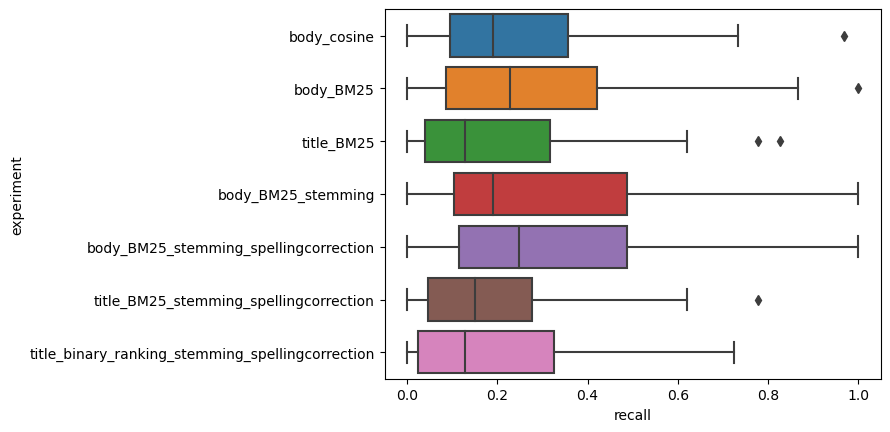

In [86]:
sns.boxplot(data=score_total_df, x="recall", y="experiment") 

<AxesSubplot:xlabel='MAPscore40', ylabel='experiment'>

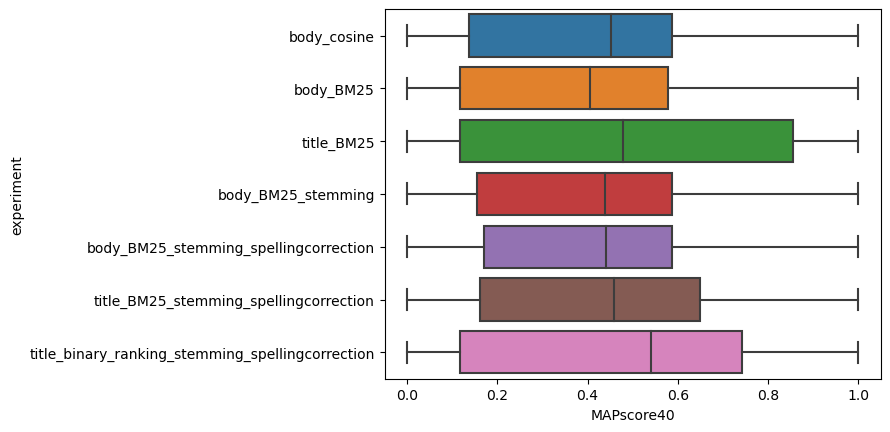

In [87]:
sns.boxplot(data=score_total_df, x="MAPscore40", y="experiment")

<AxesSubplot:xlabel='time', ylabel='experiment'>

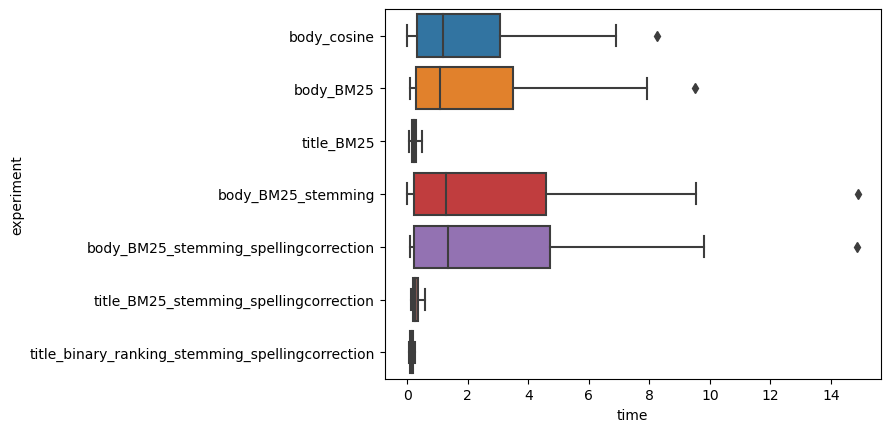

In [88]:
sns.boxplot(data=score_total_df, x="time", y="experiment")

## combine between body, title and pagerank

In [8]:
def jaccard(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    intersection = s1.intersection(s2)
    union = s1.union(s2)
    return len(intersection)/ len(union)

def tokenizer_stemming_no_stopwords_removal(text):
    """
    :param text: string
    :return: tokenized quarry with stopwords
    """
    return [stemmer.stem(token.group()) for token in RE_WORD.finditer(text.lower())]

In [11]:
def search(query):
    tokens = tokenizer_stemming(query)
    unknown_words = [token for token in tokens if token not in body_index_stemming.df and token not in all_stopwords] # words that are not in our corpus 
    
    for incorrect_word in unknown_words: # use ngram to find the closest correct word
        temp = [(jaccard_distance(set(ngrams(incorrect_word, 2)), set(ngrams(w, 2))),w) for w in correct_words if w[0]==incorrect_word[0]]
        tokens.append(stemmer.stem(sorted(temp, key = lambda val:val[0])[0][1])) # add the most similar correct word to the tokens list
    #replace unknown word with the most close word known
    for incorrect_word in unknown_words:
        tokens.remove(incorrect_word)
    
    bm = BM25_from_index(body_index_stemming, "postings_text_stemming/")
    f1 = lambda x: x if x < 1 else 10 # if title is almost identical by jacard similarity - give 10 times more score
    
    # calculate score combination between page rank, title and body
    res = sorted([(x[0], 0.35 + jaccard(tokenizer_stemming_no_stopwords_removal(title_dict[x[0]]), tokenizer_stemming_no_stopwords_removal(query)), math.log10(page_rank[x[0]] + 1) , x[1]) for x in bm.search(tokens, 300)], key = lambda t: f1(t[1]) * t[2] * t[3], reverse=True) #t1 jacard title t2 pagerank t3 body bm25 score
    res = [x[0] for x in res[:20]]
    return res

In [12]:
df = evaluate(queries_train_keys)
df

,query,MAPscore40,MAPscore100,recall,time
0,best marvel movie,0.634167,0.634167,0.212766,3.909208
1,How do kids come to world?,0.252999,0.252999,0.080000,7.115044
2,Information retrieval,0.951561,0.951561,0.388889,1.854094
3,LinkedIn,0.792157,0.792157,0.333333,0.105114
4,How to make coffee?,0.472300,0.472300,0.145833,3.379319
5,Ritalin,0.619571,0.619571,0.216216,0.095887
6,How to make wine at home?,0.332143,0.332143,0.080000,6.412742
7,Most expensive city in the world,0.266667,0.266667,0.044444,9.284434
8,India,0.333333,0.333333,0.021277,0.955122
9,how to make money fast?,0.389897,0.389897,0.145833,4.538709


In [13]:
df.describe()

,MAPscore40,MAPscore100,recall,time
count,30.000000,30.000000,30.000000,30.000000
mean,0.610804,0.610804,0.164784,2.807183
std,0.238117,0.238117,0.104377,3.331919
min,0.000000,0.000000,0.000000,0.095887
25%,0.444077,0.444077,0.091057,0.248704
50%,0.629515,0.629515,0.138134,1.299356
75%,0.796335,0.796335,0.237782,4.372388
max,1.000000,1.000000,0.388889,14.228960


In [58]:
score_total_df = pd.read_csv("home/dataproc/score_total_df")

In [59]:
score_total_df = score_total_df[score_total_df["experiment"] == "title_binary_ranking_stemming_spellingcorrection"]

In [60]:
df["experiment"] = ["edvence_ranking"] * 30
score_total_df = pd.concat([score_total_df, df])

<AxesSubplot:xlabel='MAPscore40', ylabel='experiment'>

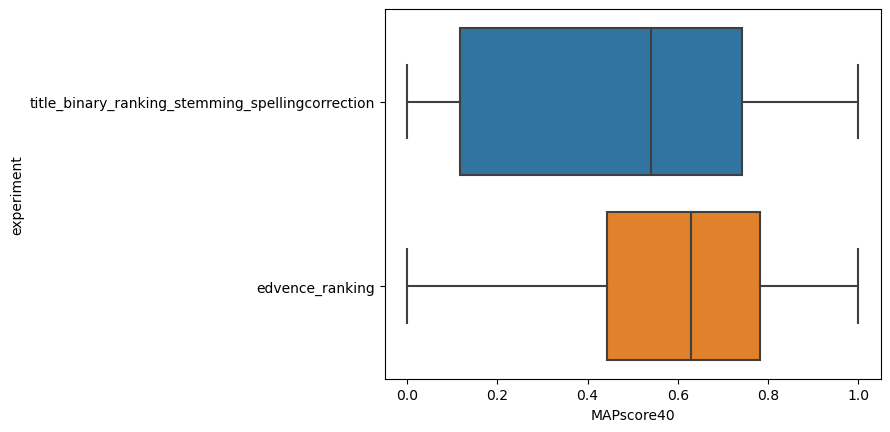

In [61]:
sns.boxplot(data=score_total_df, x="MAPscore40", y="experiment")

In [77]:
[(x, title_dict[x], x in queries_train["Rick and Morty"]) for x in search("Rick and Morty")]

[(41185040, 'Rick and Morty', True),
 (57390230, 'Rick and Morty (season 4)', True),
 (43794574, 'Rick and Morty (season 2)', True),
 (49029294, 'Rick and Morty (season 3)', True),
 (65819511, 'Rick and Morty (season 5)', True),
 (49128142, 'Pilot (Rick and Morty)', True),
 (67830379, 'Rick and Morty (franchise)', True),
 (43794572, 'Rick and Morty (season 1)', True),
 (64413225, 'Rick and Morty (soundtrack)', True),
 (326292, 'Adult Swim', False)]

In [80]:
[(x, title_dict[x], x in queries_train["What is the best place to live in?"]) for x in search("What is the best place to live in?")]

[(14330111, 'A Place in the World (film)', False),
 (21718771, 'Kerrang! Awards', False),
 (1672420, 'News & Review', False),
 (449091, 'East Hertfordshire', False),
 (108406, 'Louisville, Colorado', False),
 (19301224, 'MTV Africa Music Awards', False),
 (57746962, 'Audio and Radio Industry Awards', False),
 (40007698, 'Rüfüs Du Sol', False),
 (18093374, 'Yelizaveta Tishchenko', False),
 (24569338, "Murex d'Or", False)]

In [14]:
[(x, title_dict[x], x in queries_train["Information retrieval"]) for x in search("Information retrieval")]

[(15271, 'Information retrieval', True),
 (442684, 'Relevance (information retrieval)', True),
 (261193, 'Music information retrieval', True),
 (39000674, 'Thesaurus (information retrieval)', True),
 (296950, 'Cross-language information retrieval', True),
 (19988623, 'Ranking (information retrieval)', True),
 (24997830, 'Legal information retrieval', True),
 (33407925, 'Multimedia information retrieval', True),
 (1185840, 'Private information retrieval', True),
 (10179411, 'Geographic information retrieval', True),
 (11486091, 'Adversarial information retrieval', True),
 (36730540, 'Information Retrieved', False),
 (149354, 'Information science', False),
 (16635934, 'Information Retrieval Facility', True),
 (33736814, 'Information Retrieved Pt. B', False),
 (31594644, 'Information Retrieved, Pt. A', False),
 (35804330, 'Temporal information retrieval', True),
 (346470, 'Image retrieval', False),
 (71608, 'Document management system', False),
 (50716473, 'Evaluation measures (informatio

In [15]:
import requests

In [16]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [18]:
with open('home/dataproc/queries_train.json', 'rt') as f:
  queries = json.load(f)

In [30]:
import requests
from time import time
# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below. 
url = 'http://34.70.61.94:8080'

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [31]:
qs_res

[('best marvel movie', 4.46710729598999, 0.634),
 ('How do kids come to world?', 7.3802289962768555, 0.253),
 ('Information retrieval', 2.0927326679229736, 0.952),
 ('LinkedIn', 0.219987154006958, 0.792),
 ('How to make coffee?', 3.4026975631713867, 0.472),
 ('Ritalin', 0.19370007514953613, 0.62),
 ('How to make wine at home?', 6.4244701862335205, 0.332),
 ('Most expensive city in the world', 9.25881838798523, 0.267),
 ('India', 1.0928876399993896, 0.333),
 ('how to make money fast?', 4.6954450607299805, 0.39),
 ('Netflix', 0.24918150901794434, 0.81),
 ('Apple computer', 1.2276577949523926, 0.798),
 ('The Simpsons', 0.27979612350463867, 1.0),
 ('World cup', 5.40586519241333, 0.7),
 ('How to lose weight?', 1.4994854927062988, 0.457),
 ('Java', 0.17788934707641602, 0.656),
 ('Air Jordan', 2.2450926303863525, 0.887),
 ('how to deal with depression?', 1.62929368019104, 0.674),
 ('How do you make gold', 4.177785873413086, 0.798),
 ('Marijuana', 0.21181607246398926, 0.418),
 ('How to make hu

In [48]:
requests.post(url + '/get_pageview', json = [19988623, 14330111, 41185040, 326292], timeout=35).json()

[1171, 513, 466016, 98246]

In [55]:
requests.get(url + '/search', {'query': "omer gazit"}, timeout=35).json()

[[18472967, 'OMERS'],
 [173729, 'Saint-Omer'],
 [489430, 'Counting of the Omer'],
 [4955438, 'Shlomo Gazit'],
 [844338, 'Southern District (Israel)'],
 [17718832, 'Colleges of St Omer, Bruges and Liège'],
 [6624447, 'Omer Vrioni'],
 [1994555, 'Omer (unit)'],
 [18208079, 'Mohammed Omer'],
 [9715347, 'Omer Reingold'],
 [11104202, 'Marketwired'],
 [17384037, 'Ayesha Omer'],
 [400035, 'Omer Simeon'],
 [4353459, 'Omer, Israel'],
 [18297987, 'Ehud Gazit'],
 [2081861, 'Principality of Galilee'],
 [17762586, 'Omer Fast'],
 [38305900, 'Omer Meir Wellber'],
 [1671363, 'Lag BaOmer'],
 [2607331, 'Jezreel Valley Regional Council']]